In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab as p

import numpy as np
from IPython import embed
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.cluster import KMeans, MiniBatchKMeans
from time import time
from sklearn import metrics
from operator import itemgetter

# Loading the Data

In [2]:
def load_prepared_data():
    df_train = pd.read_csv('./data/output/processed_train.csv', header=0)
    df_test = pd.read_csv('./data/output/processed_test.csv', header=0)
    features = list(set(df_train.columns) - {'Vote'})
    target = 'Vote'

    df_train_X = df_train[features]
    df_train_Y = df_train[target]
    df_test_X = df_test[features]
    df_test_Y = df_test[target]
    # labels = {"0":"Blues","1":"Browns","2":"Greens","3":"Greys","4":"Oranges","5":"Pinks","6":"Purples","7":"Reds","8":"Whites","9":"Yellows" }
    labels = ["Blues", "Browns", "Greens", "Greys", "Oranges", "Pinks", "Purples", "Reds", "Whites", "Yellows"]
    return df_train_X, df_train_Y, df_test_X, df_test_Y, labels

# Preparing the Data

In [3]:
df_train_X, df_train_Y, df_test_X, df_test_Y, labels = load_prepared_data()
df_train_Y_nums = df_train_Y
df_test_Y_nums = df_test_Y
df_train_Y = df_train_Y.map(lambda x: labels[int(x)])
df_test_Y = df_test_Y.map(lambda x: labels[int(x)])

train_val_data = pd.concat([df_train_X])
features = train_val_data.values
labels = pd.concat([df_train_Y]).values

### Define Max K for out election - K = 25

In [4]:
max_K = 26

### Becnhmarking K-Means on out data

In [5]:
def print_bench_k_means(estimator, name, data, labels):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels, estimator.labels_),
             metrics.calinski_harabaz_score(data, estimator.labels_) ,
             metrics.silhouette_score(data, estimator.labels_, metric='euclidean', sample_size=1000))
         )

In [6]:
def loop_print_bench_k_means(data, labels, num):
    print(82 * '_')
    print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tcalinski\tsilhouette\t')
    for i in range(2, num):
        km = KMeans(n_clusters=i)
        print_bench_k_means(km, "k-means k=" + str(i), data, labels)
        
loop_print_bench_k_means(df_train_X, df_train_Y, max_K)

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	calinski	silhouette	
k-means k=2	0.19s	4247	0.273	1.000	0.429	0.193	0.273	2081.288	0.363
k-means k=3	0.04s	3468	0.273	0.593	0.374	0.173	0.273	1853.051	0.311
k-means k=4	0.05s	2710	0.274	0.432	0.335	0.151	0.273	2061.600	0.410
k-means k=5	0.07s	2045	0.274	0.353	0.308	0.127	0.273	2468.488	0.497
k-means k=6	0.06s	1656	0.274	0.312	0.292	0.111	0.272	2680.566	0.529
k-means k=7	0.08s	1300	0.302	0.318	0.310	0.116	0.300	3080.732	0.564
k-means k=8	0.07s	964	0.355	0.354	0.354	0.136	0.352	3816.999	0.598
k-means k=9	0.09s	655	0.375	0.359	0.367	0.133	0.357	5213.223	0.645
k-means k=10	0.10s	593	0.375	0.354	0.364	0.128	0.352	5177.127	0.637
k-means k=11	0.14s	547	0.375	0.351	0.362	0.125	0.348	5090.340	0.649
k-means k=12	0.17s	513	0.413	0.369	0.390	0.138	0.366	4971.783	0.617
k-means k=13	0.18s	470	0.413	0.365	0.388	0.135	0.362	5003.500	0.612
k-means k=14	0.19s	437	0.454	0.384	0.

In [7]:
def result_bench_k_means(data, labels, num):
    homogeneity_score = []
    completeness_score = []
    v_measure_score = []
    adjusted_rand_score = []
    adjusted_mutual_info_score = []
    silhouette_score = []
    calinski_harabaz_score = []
    interia = []
    
    for i in range(2, num):
        estimator = KMeans(n_clusters=i, random_state=0)
        estimator.fit(data)
        interia.append(estimator.inertia_)
        homogeneity_score.append(metrics.homogeneity_score(labels, estimator.labels_))
        completeness_score.append(metrics.completeness_score(labels, estimator.labels_))
        v_measure_score.append(metrics.v_measure_score(labels, estimator.labels_))
        adjusted_rand_score.append(metrics.adjusted_rand_score(labels, estimator.labels_))
        adjusted_mutual_info_score.append(metrics.adjusted_mutual_info_score(labels, estimator.labels_))
        silhouette_score.append(metrics.silhouette_score(data, estimator.labels_, metric='euclidean', sample_size=1000))
        calinski_harabaz_score.append(metrics.calinski_harabaz_score(data, estimator.labels_)) ,

    return {
        "interia": interia,
        "homogeneity_score": homogeneity_score,
        "completeness_score": completeness_score,
        "v_measure_score" : v_measure_score,
        "adjusted_rand_score" :adjusted_rand_score,
        "adjusted_mutual_info_score": adjusted_mutual_info_score,
        "silhouette_score" : silhouette_score,
        "calinski_harabaz_score": calinski_harabaz_score
    }

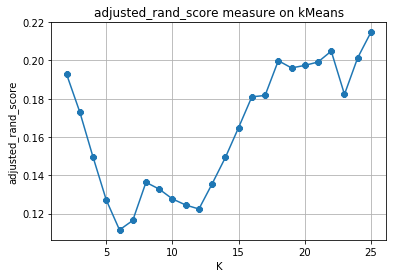

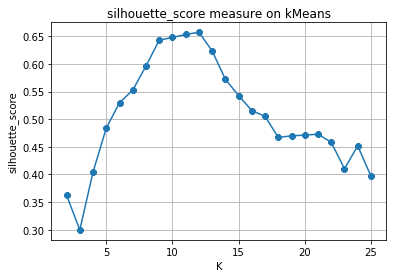

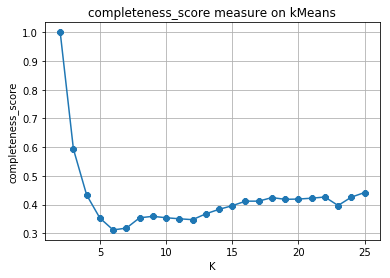

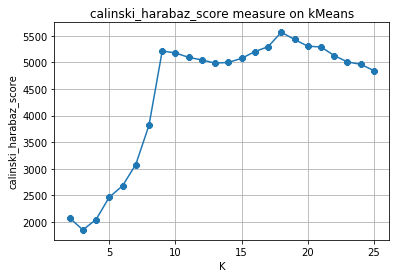

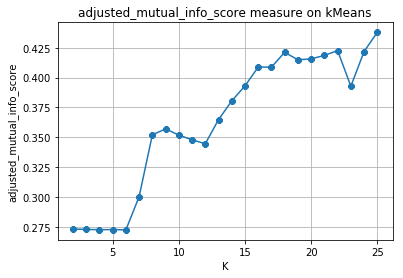

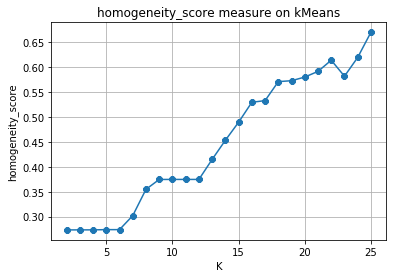

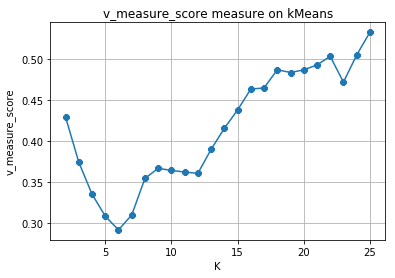

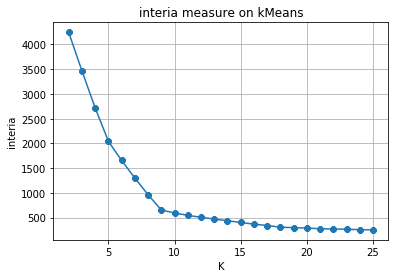

In [9]:
def draw_metrics(X, Y, k_max, inline=False):
    res = result_bench_k_means(X, Y, k_max)

    plot_x = range(2,k_max)
    
    for _metric, values in enumerate(res):
        plt.plot(plot_x, res[values], '8-')
        plt.xlabel('K')
        plt.ylabel(values)
        plt.title(values + ' measure on kMeans')
        plt.grid(True)

        plt.show()

        
draw_metrics(df_train_X, df_train_Y, max_K)

### We Chose K = 10

In [10]:
k = 10

In [11]:
km = KMeans(n_clusters=k, verbose=0, random_state=0)
print "Training: K=%d" % k
km.fit(df_train_X)
print "Done"

Training: K=10
Done


In [12]:
def k_means_party_distribution(clf, X, Y, k):
    df_Y = Y.copy().to_frame()
    df_Y['cluster'] = clf.labels_
        
    res = {}
    for i in range(0, k):
        my_df = df_Y[df_Y['cluster'] == i]
        c = Counter(my_df['Vote'].values)
        res[i] = c
    return res

In [13]:
def basic_distribution(dist):
    for key,val in dist.iteritems():
        items = val.most_common()
        keys = []
        values = []
        for item in items:
            keys.append(item[0])
            values.append(item[0])

        print "Group: %s, Distribution: %s"%(str(key), sorted(keys))

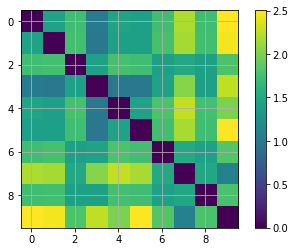

 [[ 0.     1.44   1.736  1.018  1.458  1.417  1.738  2.192  1.737  2.502]
 [ 1.44   0.     1.756  1.003  1.417  1.425  1.774  2.168  1.744  2.462]
 [ 1.736  1.756  0.     1.431  1.77   1.738  1.418  1.509  1.418  1.805]
 [ 1.018  1.003  1.431  0.     1.014  1.005  1.447  2.046  1.421  2.26 ]
 [ 1.458  1.417  1.77   1.014  0.     1.438  1.792  2.274  1.754  2.006]
 [ 1.417  1.425  1.738  1.005  1.438  0.     1.746  2.174  1.734  2.485]
 [ 1.738  1.774  1.418  1.447  1.792  1.746  0.     1.533  1.427  1.836]
 [ 2.192  2.168  1.509  2.046  2.274  2.174  1.533  0.     1.493  1.1  ]
 [ 1.737  1.744  1.418  1.421  1.754  1.734  1.427  1.493  0.     1.783]
 [ 2.502  2.462  1.805  2.26   2.006  2.485  1.836  1.1    1.783  0.   ]]


In [91]:
from sklearn import mixture
from sklearn.metrics.pairwise import euclidean_distances

gmm = mixture.GaussianMixture(n_components=k, covariance_type='full').fit(df_train_X)


def build_distance_matrix_gmm(gmm):
    m = euclidean_distances(gmm.means_, gmm.means_)
    m = np.around(m, decimals=3)
    

    matrix = np.matrix(m)
    plt.imshow(matrix, interpolation='nearest')
    plt.colorbar()
    plt.grid(True)
    plt.show()
    return matrix

gmm_dist = build_distance_matrix_gmm(gmm)
print gmm_dist

### Distrebution per cluster

In [14]:
dist_per_cluster = k_means_party_distribution(km, df_train_X, df_train_Y, k)
basic_distribution(dist_per_cluster)

Group: 0, Distribution: ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
Group: 1, Distribution: ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
Group: 2, Distribution: ['Greys', 'Oranges']
Group: 3, Distribution: ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
Group: 4, Distribution: ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
Group: 5, Distribution: ['Oranges', 'Reds']
Group: 6, Distribution: ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
Group: 7, Distribution: ['Blues', 'Yellows']
Group: 8, Distribution: ['Greys', 'Reds']
Group: 9, Distribution: ['Blues', 'Yellows']


### Distrebution per party

In [15]:
def k_means_cluster_distribution(clf, X, Y):

    df_Y = Y.copy().to_frame()
    df_Y['cluster'] = clf.labels_
        
    res = {}
    
    for i in labels:
        my_df = df_Y[df_Y['Vote'] == i]
        c = Counter(my_df['cluster'].values)
        res[i] = c
    return res


dist_per_party = k_means_cluster_distribution(km ,df_train_X, df_train_Y)
basic_distribution(dist_per_party)

Group: Reds, Distribution: [5, 8]
Group: Greens, Distribution: [0, 1, 3, 4, 6]
Group: Whites, Distribution: [0, 1, 3, 4, 6]
Group: Yellows, Distribution: [7, 9]
Group: Greys, Distribution: [2, 8]
Group: Oranges, Distribution: [2, 5]
Group: Browns, Distribution: [0, 1, 3, 4, 6]
Group: Blues, Distribution: [7, 9]
Group: Pinks, Distribution: [0, 1, 3, 4, 6]
Group: Purples, Distribution: [0, 1, 3, 4, 6]


### Summery

In [16]:
print ("_" *22) + "dist per cluster" + ("_" *22)
print "_" * 60
for i in dist_per_cluster:
    print i,dist_per_cluster[i]
    
print 
print ("_" *22) + " dist per party " + ("_" *22)
print "_" * 60    
for i in dist_per_party:
    print i,dist_per_party[i]

______________________dist per cluster______________________
____________________________________________________________
0 Counter({'Purples': 231, 'Browns': 220, 'Greens': 199, 'Pinks': 97, 'Whites': 34})
1 Counter({'Purples': 253, 'Browns': 220, 'Greens': 210, 'Pinks': 90, 'Whites': 40})
2 Counter({'Greys': 177, 'Oranges': 176})
3 Counter({'Purples': 240, 'Browns': 223, 'Greens': 191, 'Pinks': 102, 'Whites': 36})
4 Counter({'Purples': 242, 'Browns': 212, 'Greens': 167, 'Pinks': 119, 'Whites': 44})
5 Counter({'Reds': 161, 'Oranges': 142})
6 Counter({'Purples': 231, 'Browns': 206, 'Greens': 185, 'Pinks': 94, 'Whites': 35})
7 Counter({'Yellows': 190, 'Blues': 18})
8 Counter({'Greys': 156, 'Reds': 155})
9 Counter({'Yellows': 58, 'Blues': 10})

______________________ dist per party ______________________
____________________________________________________________
Reds Counter({5: 161, 8: 155})
Greens Counter({1: 210, 0: 199, 3: 191, 6: 185, 4: 167})
Whites Counter({4: 44, 1: 40, 3: 36, 

### Distances Between cluster centers

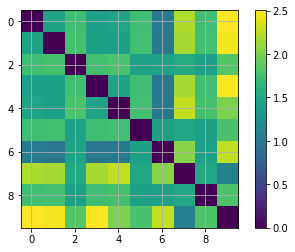

[[ 0.     1.44   1.738  1.417  1.458  1.737  1.018  2.192  1.736  2.502]]
[[ 1.44   0.     1.774  1.425  1.417  1.744  1.003  2.168  1.756  2.462]]
[[ 1.738  1.774  0.     1.746  1.792  1.427  1.447  1.533  1.418  1.836]]
[[ 1.417  1.425  1.746  0.     1.438  1.734  1.005  2.174  1.738  2.485]]
[[ 1.458  1.417  1.792  1.438  0.     1.754  1.014  2.274  1.77   2.006]]
[[ 1.737  1.744  1.427  1.734  1.754  0.     1.421  1.493  1.418  1.783]]
[[ 1.018  1.003  1.447  1.005  1.014  1.421  0.     2.046  1.431  2.26 ]]
[[ 2.192  2.168  1.533  2.174  2.274  1.493  2.046  0.     1.509  1.1  ]]
[[ 1.736  1.756  1.418  1.738  1.77   1.418  1.431  1.509  0.     1.805]]
[[ 2.502  2.462  1.836  2.485  2.006  1.783  2.26   1.1    1.805  0.   ]]


In [18]:
from sklearn.metrics.pairwise import euclidean_distances

def build_distance_matrix(clf):
    m = euclidean_distances(clf.cluster_centers_, clf.cluster_centers_)
    m = np.around(m, decimals=3)
    
#     for i in range(len(m)):
#         for j in range(len(m)):
#             if i < j:
#                 m[i][j] = 0
    
    matrix = np.matrix(m)
    plt.imshow(matrix, interpolation='nearest')
    plt.colorbar()
    plt.grid(True)
    plt.show()
    return matrix
    
matrix = build_distance_matrix(km)
for i in matrix:
    print i

### Grouping Clusters to Coalition

In [19]:
def build_candidates_for_merge(matrix):
    med = matrix.mean()
    pairs = []

    for i, line in enumerate(np.asarray(matrix)):
        for j, col in enumerate(line):
            if i < j and col < med:
                pairs.append((i,j, col))
            
    return  sorted(pairs, key=itemgetter(2))


pairs = build_candidates_for_merge(matrix)
for i in pairs:
    print i[0], sorted(dist_per_cluster[i[0]].keys())
    print i[1], sorted(dist_per_cluster[i[1]].keys())
    print "Clusters: %d --> %d, distance: %.03f"%i
    print "_" * 50

1 ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
6 ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
Clusters: 1 --> 6, distance: 1.003
__________________________________________________
3 ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
6 ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
Clusters: 3 --> 6, distance: 1.005
__________________________________________________
4 ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
6 ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
Clusters: 4 --> 6, distance: 1.014
__________________________________________________
0 ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
6 ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
Clusters: 0 --> 6, distance: 1.018
__________________________________________________
7 ['Blues', 'Yellows']
9 ['Blues', 'Yellows']
Clusters: 7 --> 9, distance: 1.100
__________________________________________________
0 ['Browns', 'Greens', 'Pinks', 'Purples', 'Whites']
3 ['Browns', 'Greens', 'Pinks', 'Purples', 'Whi

### Chosen Coalition

In [20]:
coalition = ['Purples', 'Browns', 'Greens', 'Pinks', 'Whites']
non_coalition = ['Greys', 'Oranges', 'Reds', 'Yellows', 'Blues']
coalition_clusters = [0,1,3,4,6]

## Validating Coalition size

In [21]:
def in_coal(row):
    if row["Vote"] in coalition:
        return 1
    else:
        return 0

def count_coalition(X, Y):
    df = Y.copy().to_frame()
    
    df['coal'] = df.apply (lambda row: in_coal(row),axis=1)
    val_counts = df['coal'].value_counts()
    print "In Coualtion the are %d votes which are %.02f%% percent"%(val_counts[1], float(val_counts[1]) / len(Y) * 100)


    
count_coalition(df_train_X, df_train_Y)

In Coualtion the are 3921 votes which are 75.93% percent


## Validating Coalition size on test


In [22]:
def predict_coalition(train_X, train_Y, test_X, test_Y):
    print "Training..."
    clf = RandomForestClassifier(min_samples_split=4, random_state=0)
    clf.fit(train_X, train_Y)
    print "Pridicting..."
    pred = clf.predict(test_X)
    distribution = Counter(pred)

    print "predicted winner is party ## %s ##" % distribution.most_common(1)[0][0]
    df_pred = pd.DataFrame()
    df_pred['Vote'] = pred
    count_coalition(test_X, df_pred['Vote'])
    return df_pred

def predict_clustering(clf, train_X, train_Y, test_X, test_Y):
    cluster_pred = clf.predict(test_X)
    return cluster_pred

def count_coalition_clusters(pred):
    c = Counter(pred)
    in_coal = sum(c[cid] for cid in coalition_clusters)
    total = sum(c.values())  
    print "Clustering - In Coualtion the are %d votes which are %.02f%% percent"%(in_coal, float(in_coal) / total * 100)

    
prediction = predict_coalition(df_train_X, df_train_Y, df_test_X,df_test_Y)    
clustering_prediction = predict_clustering(km, df_train_X, df_train_Y, df_test_X, df_test_Y)    
count_coalition_clusters(clustering_prediction)

Training...
Pridicting...
predicted winner is party ## Purples ##
In Coualtion the are 1315 votes which are 77.08% percent
Clustering - In Coualtion the are 1315 votes which are 77.08% percent


# Important Features

In [26]:
def transform_category(_df, name):
    for cat in _df[name].unique():
        _df[cat] = (_df[name] == cat).astype(int)
    return _df

def most_important_features_per_party(X, Y, num):
    target = pd.concat([Y]).values
    df = Y.copy().to_frame()

    df = transform_category(df, 'Vote')
    df = df.drop('Vote', axis=1)

    print '_' * 82
    res = {}
    
    for party in df.columns.values:
        # clf_tree = DecisionTreeClassifier(min_samples_split=5, random_state=0)
        clf_tree = DecisionTreeClassifier()
        clf_tree.fit(features, df[party])
        imp = clf_tree.feature_importances_
        selected_columns = []

        for i in range(len(train_val_data.columns)):
            selected_columns.append([train_val_data.columns[i], imp[i]])        
        selected_columns = sorted(selected_columns, key=itemgetter(1), reverse=True)[:num]
        res[party] = selected_columns
    return res

important_features = most_important_features_per_party(df_train_X, df_train_Y, 5)
for party in important_features:
    print party, important_features[party]

 __________________________________________________________________________________
Reds [['Overall_happiness_score', 0.39220990630207231], ['Is_Most_Important_Issue_Foreign_Affairs', 0.24373916708725785], ['Is_Most_Important_Issue_Other', 0.23984552478464385], ['Yearly_IncomeK', 0.068396457627216328], ['Garden_sqr_meter_per_person_in_residancy_area', 0.047079663097412808]]
Greens [['Overall_happiness_score', 0.7821896792973031], ['Will_vote_only_large_party', 0.14774694184035783], ['Garden_sqr_meter_per_person_in_residancy_area', 0.051778614739701509], ['Yearly_IncomeK', 0.018284764122637489], ['Is_Most_Important_Issue_Other', 0.0]]
Whites [['Yearly_IncomeK', 0.33208111889671477], ['Garden_sqr_meter_per_person_in_residancy_area', 0.22667405388465847], ['Overall_happiness_score', 0.16362064157048029], ['Will_vote_only_large_party', 0.16085689506751891], ['Avg_monthly_expense_when_under_age_21', 0.047126091145967629]]
Yellows [['Will_vote_only_large_party', 0.89343286046155113], ['Avg_S

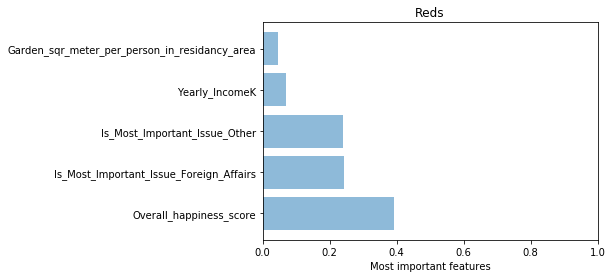

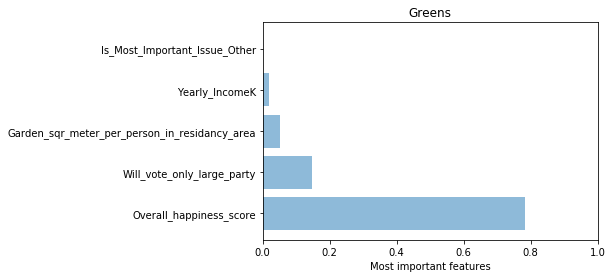

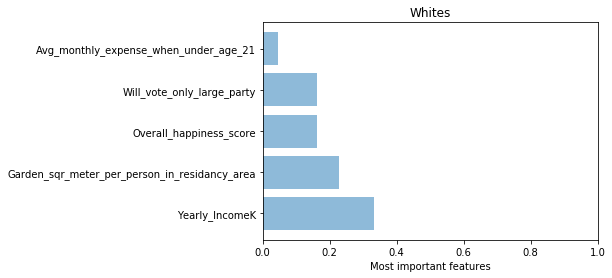

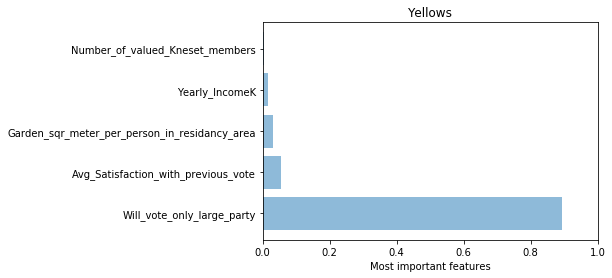

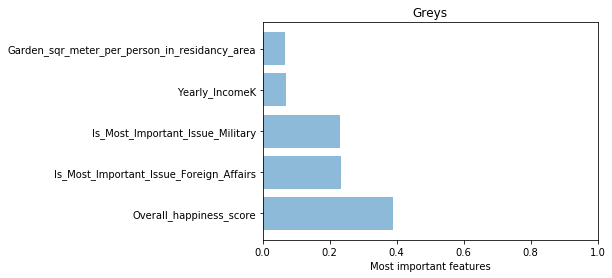

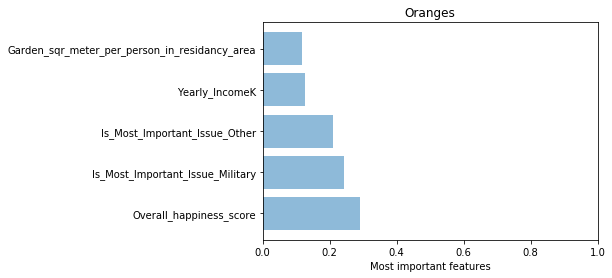

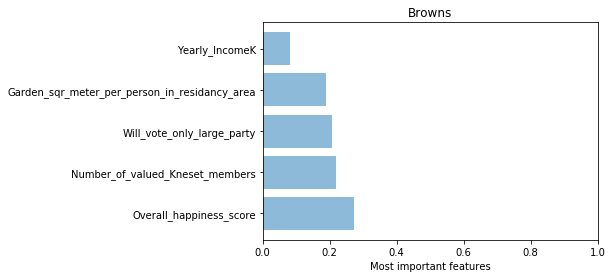

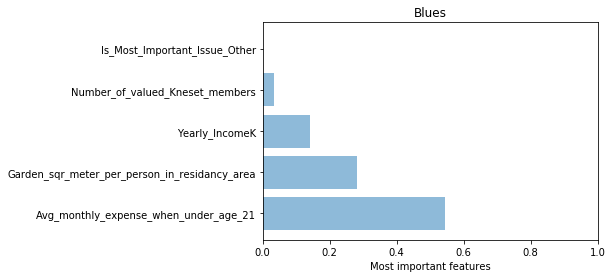

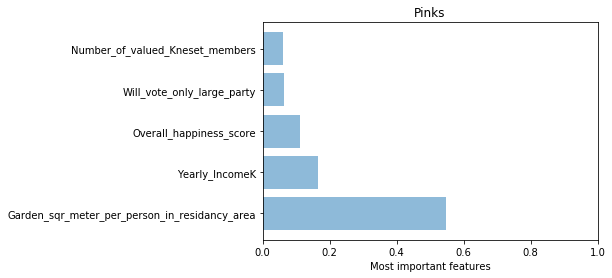

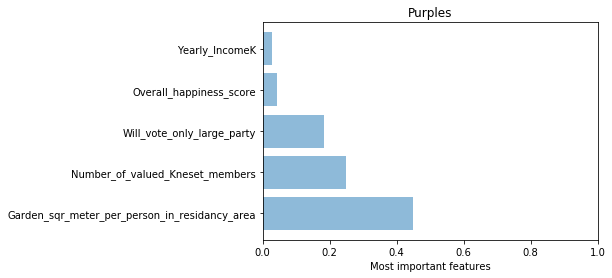

In [27]:
def draw_most_important_features_per_party(party_feature_data):
#     party_feature_data = most_important_features_per_party(num)
    for party, values in party_feature_data.iteritems():
        keys = []
        vals = []
        for i in values:
            keys.append(i[0])
            vals.append(i[1])
        
        y_pos = np.arange(len(keys))
        plt.barh(y_pos, vals, align='center', alpha=0.5)
        plt.yticks(y_pos, keys)
        plt.xlim((0,1))
        plt.title(party)
        plt.xlabel('Most important features')

        plt.show()

draw_most_important_features_per_party(important_features)

In [28]:
# important_features
def feature_score_limit(important_features, min_score, max_score=1):
    for party in important_features:
        for features in important_features[party]:
            if features[1] > min_score and features[1] <= max_score:
                print party, features

print 0.5                
feature_score_limit(important_features, 0.5)  

print "0.4 - 0.5"
feature_score_limit(important_features, 0.4, 0.5)  

print "0.3 - 0.4"
feature_score_limit(important_features, 0.3, 0.4)  

print "0.25 - 0.3"
feature_score_limit(important_features, 0.25, 0.3)

0.5
Greens ['Overall_happiness_score', 0.7821896792973031]
Yellows ['Will_vote_only_large_party', 0.89343286046155113]
Blues ['Avg_monthly_expense_when_under_age_21', 0.5441133255646895]
Pinks ['Garden_sqr_meter_per_person_in_residancy_area', 0.54879406435099243]
0.4 - 0.5
Purples ['Garden_sqr_meter_per_person_in_residancy_area', 0.44915555076381752]
0.3 - 0.4
Reds ['Overall_happiness_score', 0.39220990630207231]
Whites ['Yearly_IncomeK', 0.33208111889671477]
Greys ['Overall_happiness_score', 0.38963247539688067]
0.25 - 0.3
Oranges ['Overall_happiness_score', 0.29090348711932007]
Browns ['Overall_happiness_score', 0.27270292769744142]
Blues ['Garden_sqr_meter_per_person_in_residancy_area', 0.2829250404047508]


### Define most important features

In [29]:
improtant_features = ['Overall_happiness_score', 
                      'Avg_Satisfaction_with_previous_vote',
                      'Garden_sqr_meter_per_person_in_residancy_area',
                      'Yearly_IncomeK',
                         'Number_of_valued_Kneset_members',
                     'Avg_monthly_expense_when_under_age_21']

Coalition
___________________________________________________________________________________


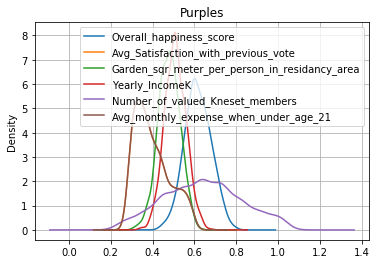

Overall_happiness_score                          0.616819
Avg_Satisfaction_with_previous_vote              0.398325
Garden_sqr_meter_per_person_in_residancy_area    0.479021
Yearly_IncomeK                                   0.508825
Number_of_valued_Kneset_members                  0.640237
Avg_monthly_expense_when_under_age_21            0.398330
dtype: float64


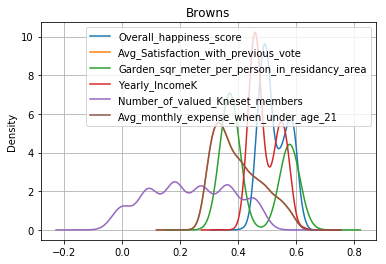

Overall_happiness_score                          0.524574
Avg_Satisfaction_with_previous_vote              0.400280
Garden_sqr_meter_per_person_in_residancy_area    0.452368
Yearly_IncomeK                                   0.493531
Number_of_valued_Kneset_members                  0.236734
Avg_monthly_expense_when_under_age_21            0.400286
dtype: float64


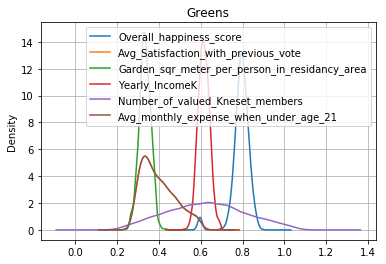

Overall_happiness_score                          0.792201
Avg_Satisfaction_with_previous_vote              0.398528
Garden_sqr_meter_per_person_in_residancy_area    0.333386
Yearly_IncomeK                                   0.614575
Number_of_valued_Kneset_members                  0.626528
Avg_monthly_expense_when_under_age_21            0.398535
dtype: float64


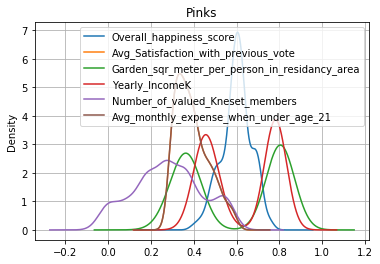

Overall_happiness_score                          0.599606
Avg_Satisfaction_with_previous_vote              0.393043
Garden_sqr_meter_per_person_in_residancy_area    0.581322
Yearly_IncomeK                                   0.620426
Number_of_valued_Kneset_members                  0.279609
Avg_monthly_expense_when_under_age_21            0.393048
dtype: float64


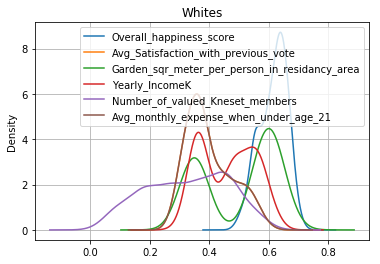

Overall_happiness_score                          0.614430
Avg_Satisfaction_with_previous_vote              0.399209
Garden_sqr_meter_per_person_in_residancy_area    0.500390
Yearly_IncomeK                                   0.460230
Number_of_valued_Kneset_members                  0.325156
Avg_monthly_expense_when_under_age_21            0.399214
dtype: float64
Non Coalition
___________________________________________________________________________________


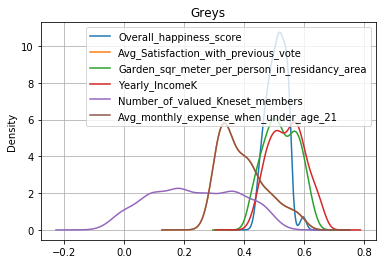

Overall_happiness_score                          0.507862
Avg_Satisfaction_with_previous_vote              0.395749
Garden_sqr_meter_per_person_in_residancy_area    0.522957
Yearly_IncomeK                                   0.543334
Number_of_valued_Kneset_members                  0.235872
Avg_monthly_expense_when_under_age_21            0.395754
dtype: float64


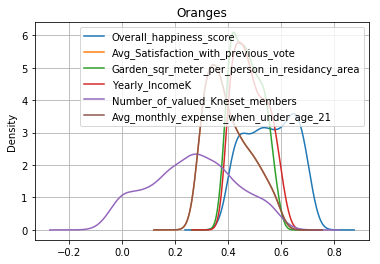

Overall_happiness_score                          0.557969
Avg_Satisfaction_with_previous_vote              0.401440
Garden_sqr_meter_per_person_in_residancy_area    0.471090
Yearly_IncomeK                                   0.485295
Number_of_valued_Kneset_members                  0.267296
Avg_monthly_expense_when_under_age_21            0.401449
dtype: float64


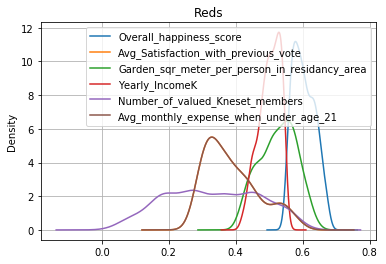

Overall_happiness_score                          0.603862
Avg_Satisfaction_with_previous_vote              0.389385
Garden_sqr_meter_per_person_in_residancy_area    0.525668
Yearly_IncomeK                                   0.500957
Number_of_valued_Kneset_members                  0.330840
Avg_monthly_expense_when_under_age_21            0.389392
dtype: float64


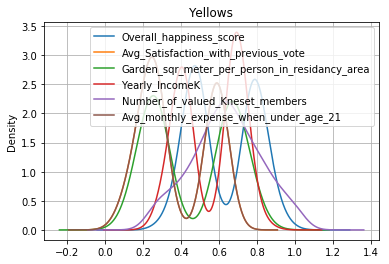

Overall_happiness_score                          0.623935
Avg_Satisfaction_with_previous_vote              0.376089
Garden_sqr_meter_per_person_in_residancy_area    0.461840
Yearly_IncomeK                                   0.558259
Number_of_valued_Kneset_members                  0.637097
Avg_monthly_expense_when_under_age_21            0.376094
dtype: float64


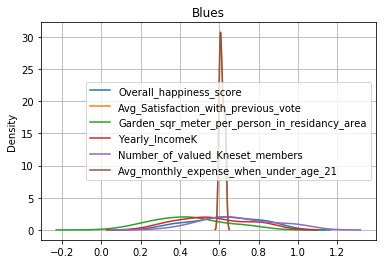

Overall_happiness_score                          0.631023
Avg_Satisfaction_with_previous_vote              0.614055
Garden_sqr_meter_per_person_in_residancy_area    0.444156
Yearly_IncomeK                                   0.567143
Number_of_valued_Kneset_members                  0.701299
Avg_monthly_expense_when_under_age_21            0.614055
dtype: float64


In [30]:
def plot_feature_distriution(parties, my_features, X, Y):
    for party in parties:
        df_party = X.copy()
        df_party['Vote'] = Y
        df_party = df_party[df_party['Vote'] == party]
        df_party = df_party[my_features]
        df_party.plot(kind='kde') 
        p.title(party)
        p.grid(True)
        p.show()
        print df_party[my_features].mean()
        
print "Coalition"
print "_" * 83
plot_feature_distriution(coalition, improtant_features, df_train_X, df_train_Y)
print "Non Coalition"
print "_" * 83
plot_feature_distriution(non_coalition, improtant_features, df_train_X, df_train_Y)

In [31]:
def show_feature_party(feature, party):
    df_party = df_train_X.dropna().copy()
    df_party['Vote'] = df_train_Y
    df_party = df_party[df_party['Vote'] == party]
    df_party[feature].plot(kind='kde')
    p.xlim(0,1)
    p.title(party + " " + feature)
    p.show()

    print df_party[feature].describe()

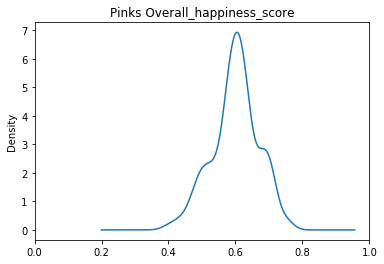

count    502.000000
mean       0.599606
std        0.069037
min        0.389090
25%        0.566959
50%        0.602884
75%        0.637368
max        0.767239
Name: Overall_happiness_score, dtype: float64


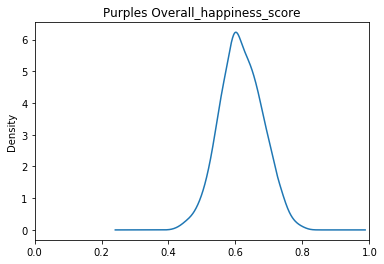

count    1197.000000
mean        0.616819
std         0.063413
min         0.427669
25%         0.573691
50%         0.614665
75%         0.661030
max         0.800784
Name: Overall_happiness_score, dtype: float64


In [32]:
show_feature_party('Overall_happiness_score', 'Pinks')
show_feature_party('Overall_happiness_score', 'Purples')

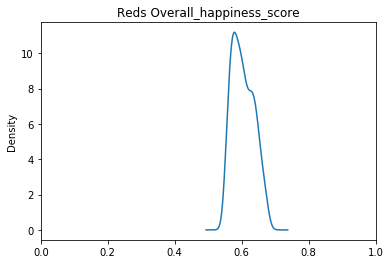

count    316.000000
mean       0.603862
std        0.032113
min        0.554507
25%        0.576249
50%        0.599125
75%        0.629102
max        0.676458
Name: Overall_happiness_score, dtype: float64


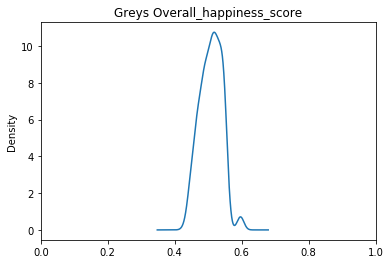

count    333.000000
mean       0.507862
std        0.032364
min        0.430653
25%        0.484119
50%        0.510695
75%        0.532026
max        0.596359
Name: Overall_happiness_score, dtype: float64


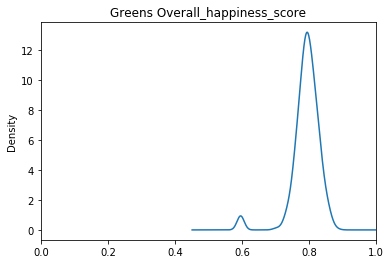

count    952.000000
mean       0.792201
std        0.042332
min        0.596359
25%        0.777251
50%        0.796059
75%        0.815905
max        0.885924
Name: Overall_happiness_score, dtype: float64


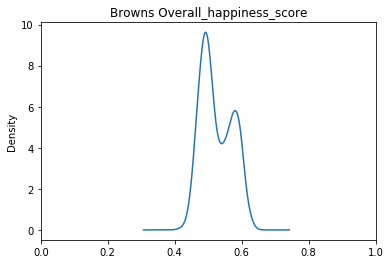

count    1081.000000
mean        0.524574
std         0.046820
min         0.415764
25%         0.486321
50%         0.511425
75%         0.568671
max         0.633434
Name: Overall_happiness_score, dtype: float64


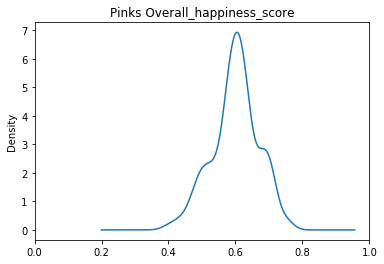

count    502.000000
mean       0.599606
std        0.069037
min        0.389090
25%        0.566959
50%        0.602884
75%        0.637368
max        0.767239
Name: Overall_happiness_score, dtype: float64


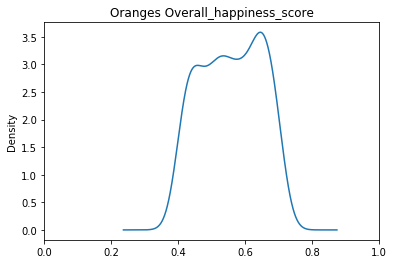

count    318.000000
mean       0.557969
std        0.090425
min        0.396051
25%        0.478319
50%        0.558866
75%        0.638340
max        0.714857
Name: Overall_happiness_score, dtype: float64


In [33]:
show_feature_party('Overall_happiness_score', 'Reds')   
show_feature_party('Overall_happiness_score', 'Greys')
show_feature_party('Overall_happiness_score', 'Greens')
show_feature_party('Overall_happiness_score', 'Browns')
show_feature_party('Overall_happiness_score', 'Pinks')
show_feature_party('Overall_happiness_score', 'Oranges')

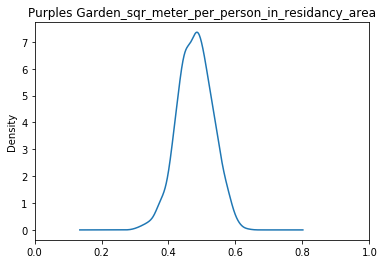

count    1197.000000
mean        0.479021
std         0.051926
min         0.301663
25%         0.444044
50%         0.479641
75%         0.514225
max         0.634784
Name: Garden_sqr_meter_per_person_in_residancy_area, dtype: float64


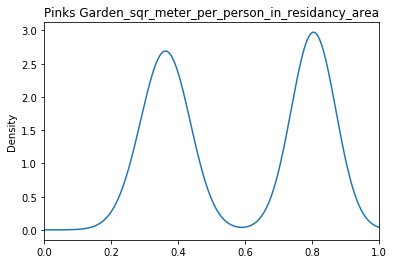

count    502.000000
mean       0.581322
std        0.223897
min        0.238826
25%        0.362983
50%        0.449198
75%        0.806789
max        0.845800
Name: Garden_sqr_meter_per_person_in_residancy_area, dtype: float64


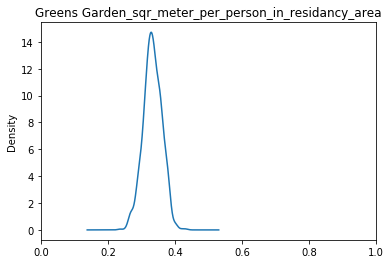

count    952.000000
mean       0.333386
std        0.027381
min        0.236357
25%        0.316374
50%        0.332777
75%        0.352875
max        0.432771
Name: Garden_sqr_meter_per_person_in_residancy_area, dtype: float64


In [34]:
show_feature_party('Garden_sqr_meter_per_person_in_residancy_area', 'Purples')   
show_feature_party('Garden_sqr_meter_per_person_in_residancy_area', 'Pinks')
show_feature_party('Garden_sqr_meter_per_person_in_residancy_area', 'Greens')

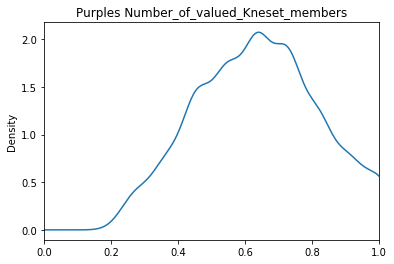

count    1197.000000
mean        0.640237
std         0.182857
min         0.272727
25%         0.545455
50%         0.636364
75%         0.727273
max         1.000000
Name: Number_of_valued_Kneset_members, dtype: float64


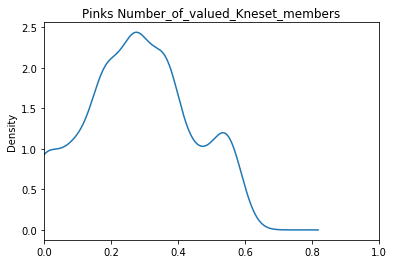

count    502.000000
mean       0.279609
std        0.157989
min        0.000000
25%        0.181818
50%        0.272727
75%        0.363636
max        0.545455
Name: Number_of_valued_Kneset_members, dtype: float64


In [35]:
show_feature_party('Number_of_valued_Kneset_members', 'Purples')   
show_feature_party('Number_of_valued_Kneset_members', 'Pinks')

In [36]:
def pick_a_new_winner(train_X, train_Y, test_X, test_Y):
    clf = RandomForestClassifier(min_samples_split=4, random_state=0)
    clf.fit(train_X, train_Y)

    pred = clf.predict(test_X)    
    distribution = Counter(pred)

    print "Original winner is party ## %s ##" % distribution.most_common(1)[0][0]
    print ""    

    print "Garden_sqr_meter_per_person_in_residancy_area = 0.33"
    new_test_X = test_X.copy()
    new_test_X['Garden_sqr_meter_per_person_in_residancy_area'] = 0.33
    
    pred = clf.predict(new_test_X)    
    distribution = Counter(pred)
    print "winner is party ## %s ##" % distribution.most_common(1)[0][0]
    print ""
    
    print "Will_vote_only_large_party = 0.9"
    new_test_X = test_X.copy()
    new_test_X['Will_vote_only_large_party'] = 0.9
    
    
    pred = clf.predict(new_test_X)    
    distribution = Counter(pred)
    print "winner is party ## %s ##" % distribution.most_common(1)[0][0]
    print ""
    
    print "Number_of_valued_Kneset_members = 0.236734"
    new_test_X = test_X.copy()
    new_test_X['Number_of_valued_Kneset_members'] = 0.236734

    
    pred = clf.predict(new_test_X)    
    distribution = Counter(pred)
    print "winner is party ## %s ##" % distribution.most_common(1)[0][0]
    print ""
    
    print "Garden_sqr_meter_per_person_in_residancy_area /= 0.236734"
    print "Number_of_valued_Kneset_members -= 0.23"
    new_test_X = test_X.copy()
    new_test_X['Garden_sqr_meter_per_person_in_residancy_area'] = new_test_X['Garden_sqr_meter_per_person_in_residancy_area'] /2
    new_test_X['Number_of_valued_Kneset_members'] = new_test_X['Number_of_valued_Kneset_members'] - 0.23


    pred = clf.predict(new_test_X)    
    distribution = Counter(pred)
    print "winner is party ## %s ##" % distribution.most_common(1)[0][0]
    print ""
    

pick_a_new_winner(df_train_X, df_train_Y, df_test_X, df_test_Y)

Original winner is party ## Purples ##

Garden_sqr_meter_per_person_in_residancy_area = 0.33
winner is party ## Greens ##

Will_vote_only_large_party = 0.9
winner is party ## Yellows ##

Number_of_valued_Kneset_members = 0.236734
winner is party ## Browns ##

Garden_sqr_meter_per_person_in_residancy_area /= 0.236734
Number_of_valued_Kneset_members -= 0.23
winner is party ## Pinks ##



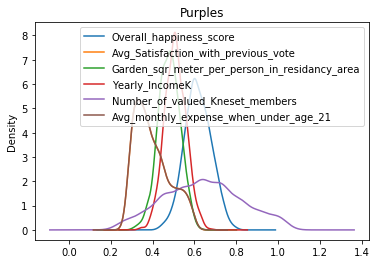

Overall_happiness_score                          0.616819
Avg_Satisfaction_with_previous_vote              0.398325
Garden_sqr_meter_per_person_in_residancy_area    0.479021
Yearly_IncomeK                                   0.508825
Number_of_valued_Kneset_members                  0.640237
Avg_monthly_expense_when_under_age_21            0.398330
dtype: float64


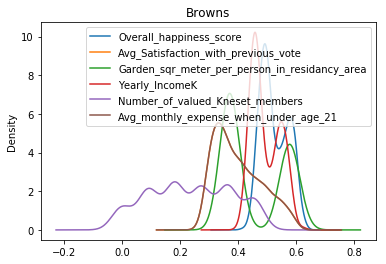

Overall_happiness_score                          0.524574
Avg_Satisfaction_with_previous_vote              0.400280
Garden_sqr_meter_per_person_in_residancy_area    0.452368
Yearly_IncomeK                                   0.493531
Number_of_valued_Kneset_members                  0.236734
Avg_monthly_expense_when_under_age_21            0.400286
dtype: float64


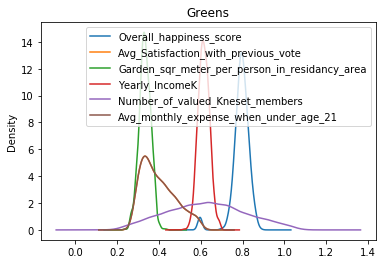

Overall_happiness_score                          0.792201
Avg_Satisfaction_with_previous_vote              0.398528
Garden_sqr_meter_per_person_in_residancy_area    0.333386
Yearly_IncomeK                                   0.614575
Number_of_valued_Kneset_members                  0.626528
Avg_monthly_expense_when_under_age_21            0.398535
dtype: float64


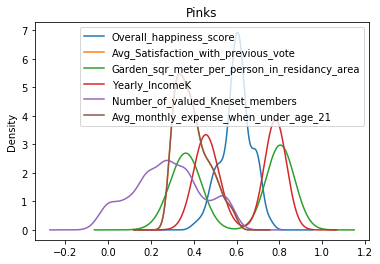

Overall_happiness_score                          0.599606
Avg_Satisfaction_with_previous_vote              0.393043
Garden_sqr_meter_per_person_in_residancy_area    0.581322
Yearly_IncomeK                                   0.620426
Number_of_valued_Kneset_members                  0.279609
Avg_monthly_expense_when_under_age_21            0.393048
dtype: float64


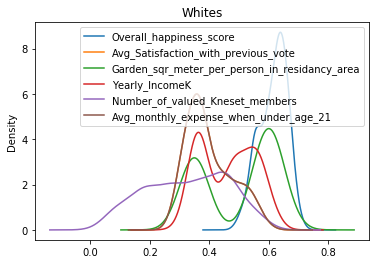

Overall_happiness_score                          0.614430
Avg_Satisfaction_with_previous_vote              0.399209
Garden_sqr_meter_per_person_in_residancy_area    0.500390
Yearly_IncomeK                                   0.460230
Number_of_valued_Kneset_members                  0.325156
Avg_monthly_expense_when_under_age_21            0.399214
dtype: float64


In [37]:
for party in coalition:
    df_party = df_train_X.dropna().copy()
    df_party['Vote'] = df_train_Y
    df_party = df_party[df_party['Vote'] == party]
    df_party[improtant_features].plot(kind='kde') 
    p.title(party)
    p.show()
    print df_party[improtant_features].mean()

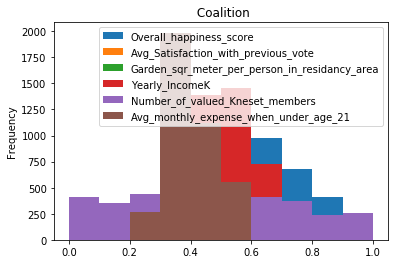

Overall_happiness_score                          0.631650
Avg_Satisfaction_with_previous_vote              0.398280
Garden_sqr_meter_per_person_in_residancy_area    0.450441
Yearly_IncomeK                                   0.542230
Number_of_valued_Kneset_members                  0.464306
Avg_monthly_expense_when_under_age_21            0.398285
dtype: float64


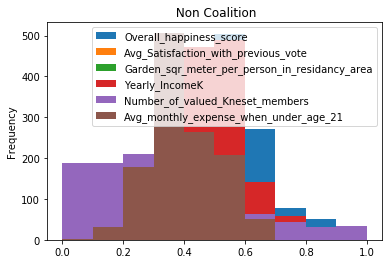

Overall_happiness_score                          0.571020
Avg_Satisfaction_with_previous_vote              0.396582
Garden_sqr_meter_per_person_in_residancy_area    0.496408
Yearly_IncomeK                                   0.521226
Number_of_valued_Kneset_members                  0.358590
Avg_monthly_expense_when_under_age_21            0.396589
dtype: float64


In [72]:
df_party = df_train_X.dropna().copy()
df_party['Vote'] = df_train_Y
df_party = df_party[df_party['Vote'].isin(coalition)]
df_party[improtant_features].plot(kind='kde') 
p.title(" Coalition")
p.show()

print df_party[improtant_features].mean()

df_party = df_train_X.dropna().copy()
df_party['Vote'] = df_train_Y
df_party = df_party[df_party['Vote'].isin(non_coalition)]
df_party[improtant_features].plot(kind='kde') 
p.title(" Non Coalition")
p.show()

print df_party[improtant_features].mean()

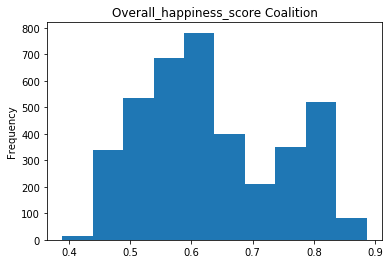

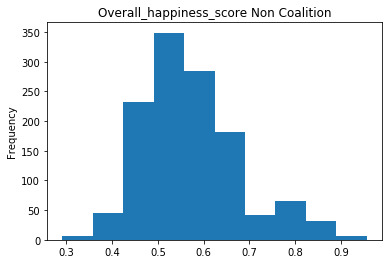

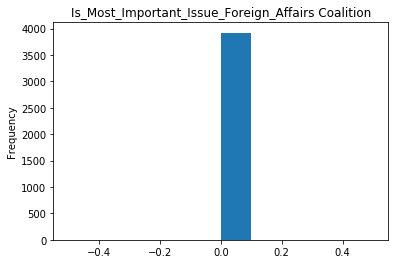

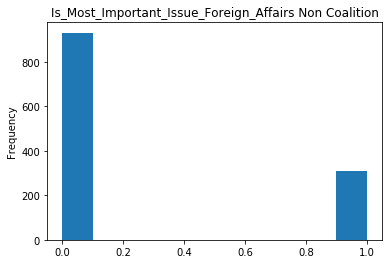

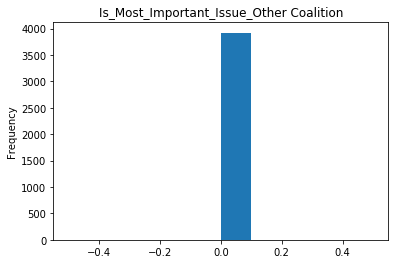

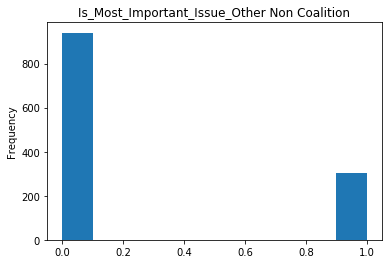

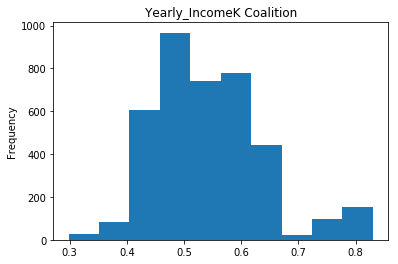

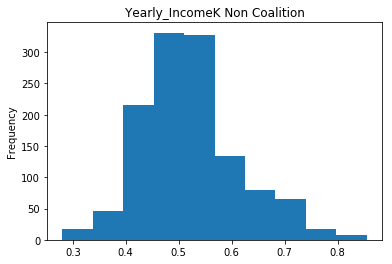

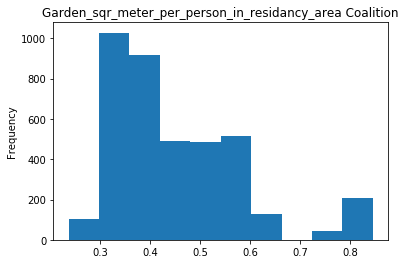

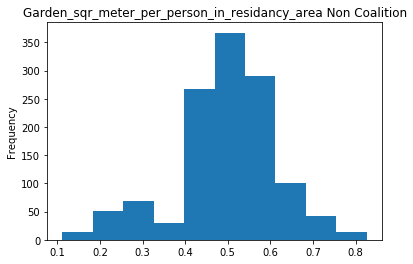

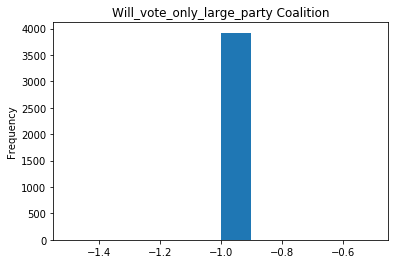

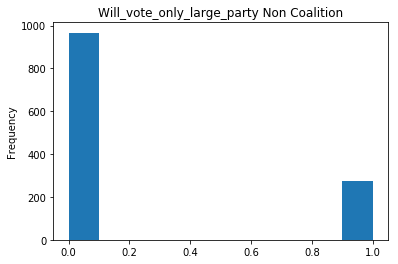

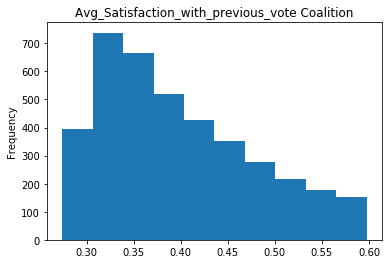

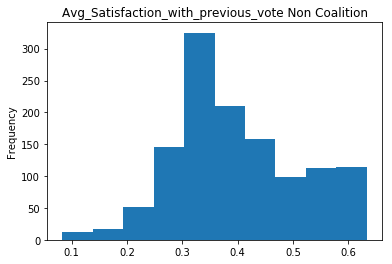

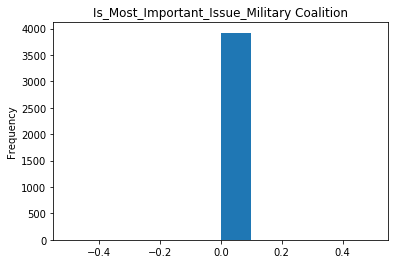

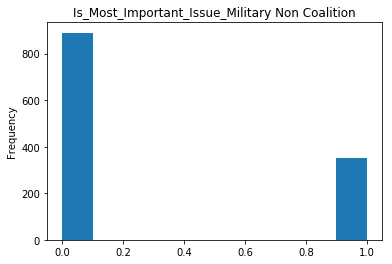

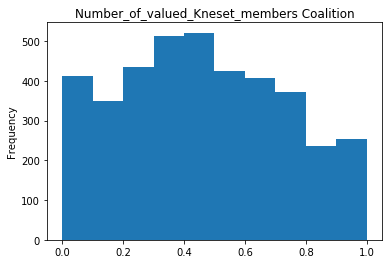

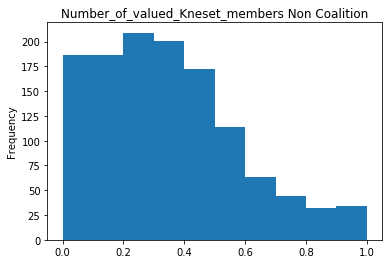

In [73]:
def hist_plot(feat):
    for f in feat:
        df_party = df_train_X.dropna().copy()
        df_party['Vote'] = df_train_Y
        df_party = df_party[df_party['Vote'].isin(coalition)]
        df_party[f].plot(kind='hist') 
        p.title(f + " Coalition")
        p.show()

        df_party = df_train_X.dropna().copy()
        df_party['Vote'] = df_train_Y
        df_party = df_party[df_party['Vote'].isin(non_coalition)]
        df_party[f].plot(kind='hist') 
        p.title(f + " Non Coalition")
        p.show()

hist_plot(['Overall_happiness_score',
 'Is_Most_Important_Issue_Foreign_Affairs',
 'Is_Most_Important_Issue_Other',
 'Yearly_IncomeK',
 'Garden_sqr_meter_per_person_in_residancy_area',
'Will_vote_only_large_party','Avg_Satisfaction_with_previous_vote','Is_Most_Important_Issue_Military','Number_of_valued_Kneset_members'])

In [65]:
def change_coalition(train_X, train_Y, test_X, test_Y):
    clf = RandomForestClassifier(min_samples_split=4, random_state=0)
    clf.fit(train_X, train_Y)

    pred = clf.predict(test_X)    
    distribution = Counter(pred)

    print "Original winner is party ## %s ##" % distribution.most_common(1)[0][0]
    pred = clf.predict(test_X)    
    distribution = Counter(pred)
    print "winner is party ## %s ##" % distribution.most_common(1)[0][0]
    print distribution
    df_pred = pd.DataFrame()
    df_pred['Vote'] = pred
    count_coalition(test_X, df_pred['Vote'])
    print ""
    

    new_test_X = test_X.copy()
    new_test_X['Will_vote_only_large_party'] = new_test_X['Will_vote_only_large_party'] / 3 + 0.66


    pred = clf.predict(new_test_X)    
    distribution = Counter(pred)
    print "winner is party ## %s ##" % distribution.most_common(1)[0][0]
    print distribution
    df_pred = pd.DataFrame()
    df_pred['Vote'] = pred
    count_coalition(new_test_X, df_pred['Vote'])
    print ""



change_coalition(df_train_X, df_train_Y, df_test_X, df_test_Y)

Original winner is party ## Purples ##
winner is party ## Purples ##
Counter({'Purples': 410, 'Browns': 399, 'Greens': 315, 'Pinks': 144, 'Reds': 118, 'Greys': 102, 'Oranges': 95, 'Yellows': 73, 'Whites': 47, 'Blues': 3})
In Coualtion the are 1315 votes which are 77.08% percent


winner is party ## Yellows ##
Counter({'Yellows': 401, 'Purples': 304, 'Browns': 275, 'Oranges': 270, 'Reds': 171, 'Greys': 136, 'Pinks': 107, 'Greens': 31, 'Whites': 6, 'Blues': 5})
In Coualtion the are 723 votes which are 42.38% percent



In [ ]:
from operator import itemgetter

def most_important_features_per_party(num):
    target = pd.concat([df_train_Y]).values
    df = df_train_Y.copy().to_frame()

    df = transform_category(df, 'Vote')
    df = df.drop('Vote', axis=1)

    print '_' * 82
    res = {}
    
    for party in df.columns.values:
        # clf_tree = DecisionTreeClassifier(min_samples_split=5, random_state=0)
        clf_tree = DecisionTreeClassifier()
        clf_tree.fit(features, df[party])
        imp = clf_tree.feature_importances_
        selected_columns = []

        for i in range(len(train_val_data.columns)):
            selected_columns.append([train_val_data.columns[i], imp[i]])        
        selected_columns = sorted(selected_columns, key=itemgetter(1), reverse=True)[:num]
        res[party] = selected_columns
    return res

In [ ]:
def most_important_features_overall():
    target = pd.concat([df_train_Y]).values
    df = df_train_Y.copy().to_frame()

    df = transform_category(df, 'Vote')
    df = df.drop('Vote', axis=1)

    selected_columns = []

    for party in df.columns.values:
        clf_tree = DecisionTreeClassifier(min_samples_split=5, random_state=0)
        clf_tree.fit(features, df[party])
        imp = clf_tree.feature_importances_
        result = imp > np.percentile(imp, pecentile)

        for i in range(len(result)):
            if result[i]:
                selected_columns.append(train_val_data.columns[i])

    print '_' * 82
    print Counter(selected_columns)

In [ ]:
def most_important_features_per_coalition():
    target = pd.concat([df_train_Y]).values
    df = df_train_Y.copy().to_frame()

    df = transform_category(df, 'Vote')
    df = df.drop('Vote', axis=1)
    
    coalition_columns = []
    non_coalition_columns = []

    for party in df.columns.values:
        clf_tree = DecisionTreeClassifier(min_samples_split=5, random_state=0)
        clf_tree.fit(features, df[party])
        imp = clf_tree.feature_importances_
        result = imp > np.percentile(imp, pecentile)

        for i in range(len(result)):
            if result[i]:
                if party in coalition:
                    coalition_columns.append(train_val_data.columns[i])
                else:
                    non_coalition_columns.append(train_val_data.columns[i])

    print '_' * 82
    print "Coalition", Counter(coalition_columns)
    print '_' * 82
    print "Non Coalition", Counter(non_coalition_columns)
    print '_' * 82

In [ ]:
def x():
    df_train_X, df_train_Y, df_test_X, df_test_Y, labels = load_prepared_data()

    train_val_data = pd.concat([df_train_X])
    features = train_val_data.values
    target = pd.concat([df_train_Y]).values
    
    features_test = df_test_X
    target_test = df_test_Y
    
#     df_test_X['Overall_happiness_score'] = df_test_X['Overall_happiness_score'] + 0.2
    df_test_X['Garden_sqr_meter_per_person_in_residancy_area'] = 0.33
#     df_test_X['Overall_happiness_score'] = 0.6
#     df_test_X['Will_vote_only_large_party'] = df_test_X['Will_vote_only_large_party'] * 0.20337318982798203
    
    
    
    
    
    clf = DecisionTreeClassifier(min_samples_split=8)
    clf.fit(features, target)
    
    pred = clf.predict(features_test)

    distribution = np.bincount(pred.astype('int64'))
    most_common = np.argmax(distribution)

    print "winner is party ## %s ##" % labels[most_common.astype('int')]

    print "Vote distribution"
    distribution = np.bincount(pred.astype('int64'))

    for index,party in enumerate(distribution):
        print "%s, %f, %f"%(labels[index], distribution[index], distribution[index]/ float(target_test.size) * 100) + '%'
    
    df_pred = pd.DataFrame()
    df_pred['Vote'] = pred
    k_means(5, features_test, df_pred['Vote'].map(lambda x: labels[int(x)]))
    
x()